# Perform imports

In [621]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import copy

# Load CIFAR-10 dataset
## Create loader

In [622]:
# Load dataset (CIFAR-10)
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Device configuration

In [623]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Model

In [624]:
class ConvSize:
    def __init__(self, height, width, channels=None):
        self.height = height
        self.width = width
        self.channels = channels

def calc_conv2d_out_size(c_in, h_in, w_in, c_out, kernel_size, padding, stride, distilation=1):
    h_out = (h_in + 2 * padding - distilation * (kernel_size - 1) - 1)/stride + 1
    w_out = (w_in + 2 * padding - distilation * (kernel_size - 1) - 1)/stride + 1
    return ConvSize(height=int(h_out), width=int(w_out), channels=int(c_out))

def calc_conv_transpose2d_out_size(c_in, h_in, w_in, c_out, kernel_size, padding, stride, distilation=1):
    h_out = (h_in - 1) * stride - 2 * padding + distilation * (kernel_size - 1) + 1
    w_out = (w_in - 1) * stride - 2 * padding + distilation * (kernel_size - 1) + 1
    return ConvSize(height=int(h_out), width=int(w_out), channels=int(c_out))

class EncoderDecoder(nn.Module):
    def __init__(self, embedding_dim, h_in=32, w_in=32, channel_in=3, channels=[64, 32], kernel_size=4, padding=1, stride=2):
        super(EncoderDecoder, self).__init__()
        # Encoder layers
        self.encoder_output_size = self.init_encoder(channels=channels, channel_in=channel_in, kernel_size=kernel_size, h_in=h_in, w_in=w_in, padding=padding, stride=stride)
        
        # Embedding layer
        self.embedding = nn.Linear(self.encoder_output_size.channels * self.encoder_output_size.height * self.encoder_output_size.width, embedding_dim)

        # Decoder layers
        self.decoder_input = nn.Linear(embedding_dim, self.encoder_output_size.channels * self.encoder_output_size.height * self.encoder_output_size.width)
        self.decoder_output_size = self.init_decoder(channels=channels, channel_in=channel_in, kernel_size=kernel_size, padding=padding, stride=stride)

    def init_encoder(self, channels, channel_in, h_in, w_in, kernel_size, padding, stride):
        nn_layers = []
        output_size = ConvSize(height=h_in, width=w_in)
        prev_channel = channel_in
        for channel in channels:
            output_size = calc_conv2d_out_size(c_in=prev_channel, h_in=output_size.height, w_in=output_size.width, c_out=channel, kernel_size=kernel_size, padding=padding, stride=stride)
            nn_layers.append(nn.Conv2d(prev_channel, channel, kernel_size=kernel_size, stride=stride, padding=padding))
            prev_channel = channel
            nn_layers.append(nn.RReLU())
        self.encoder = nn.Sequential(*nn_layers)
        return output_size

    def init_decoder(self, channels, channel_in, kernel_size, padding, stride):
        nn_layers = []
        prev_channel = self.encoder_output_size.channels
        output_size = copy.deepcopy(self.encoder_output_size)
        
        reverse_channels = channels[::-1]
        reverse_channels = reverse_channels[1:]
        reverse_channels.append(channel_in)
        print(f'reverse_channels: {reverse_channels}')
        for channel in reverse_channels:
            output_size = calc_conv_transpose2d_out_size(c_in=prev_channel, h_in=output_size.height, w_in=output_size.width, c_out=channel, kernel_size=kernel_size, padding=padding, stride=stride)
            print(output_size)
            nn_layers.append(nn.ConvTranspose2d(prev_channel, channel, kernel_size=kernel_size, stride=stride, padding=padding))
            prev_channel = channel
            nn_layers.append(nn.RReLU())
        nn_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*nn_layers)
        return 
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        y = self.embedding(x)
        return y

    def decode(self, y):
        x = self.decoder_input(y)
        x = x.view(x.size(0), self.encoder_output_size.channels, self.encoder_output_size.height, self.encoder_output_size.width)
        x = self.decoder(x)
        return x

    def forward(self, x):
        x_encoded = self.encode(x)
        x_recreated = self.decode(x_encoded)
        return x_recreated

# Create Model

In [625]:
torch.manual_seed(102)
model = EncoderDecoder(embedding_dim=1024, channels=[16, 128]).to(device)
model

reverse_channels: [16, 3]


EncoderDecoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): RReLU(lower=0.125, upper=0.3333333333333333)
    (2): Conv2d(16, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): RReLU(lower=0.125, upper=0.3333333333333333)
  )
  (embedding): Linear(in_features=8192, out_features=1024, bias=True)
  (decoder_input): Linear(in_features=1024, out_features=8192, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): RReLU(lower=0.125, upper=0.3333333333333333)
    (2): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): RReLU(lower=0.125, upper=0.3333333333333333)
    (4): Sigmoid()
  )
)

# Train the model

In [626]:
# Define the optimizer

optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 10

train_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    
    # Run the training batches
    for _, (X_train, _) in enumerate(train_loader):

        X_train = X_train.to(device)
        
        # Apply the model
        Y_pred = model(X_train)
        loss = F.mse_loss(Y_pred, X_train)

        epoch_loss += loss.item()
                
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
    train_losses.append(epoch_loss)
    print(f"====> Epoch: {epoch}, Loss: {epoch_loss:.4f}")
        

====> Epoch: 0, Loss: 19.5891
====> Epoch: 1, Loss: 10.3850
====> Epoch: 2, Loss: 8.2124
====> Epoch: 3, Loss: 6.9850
====> Epoch: 4, Loss: 6.1620
====> Epoch: 5, Loss: 5.4950
====> Epoch: 6, Loss: 4.9818
====> Epoch: 7, Loss: 4.5803
====> Epoch: 8, Loss: 4.2418
====> Epoch: 9, Loss: 3.9600


# Plot the loss

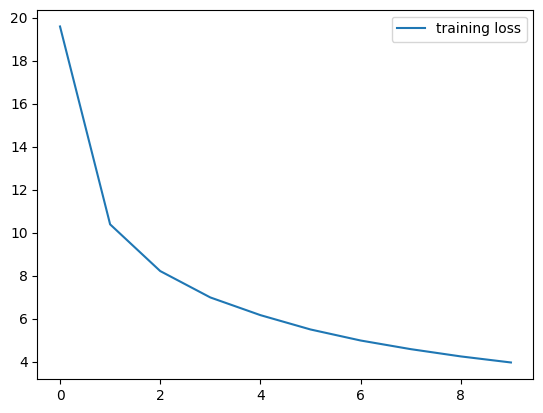

In [627]:
plt.plot(train_losses, label='training loss')
plt.legend();

# Display images 

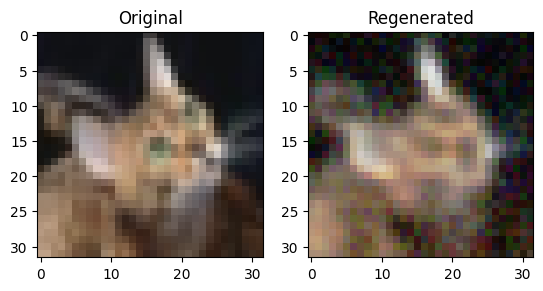

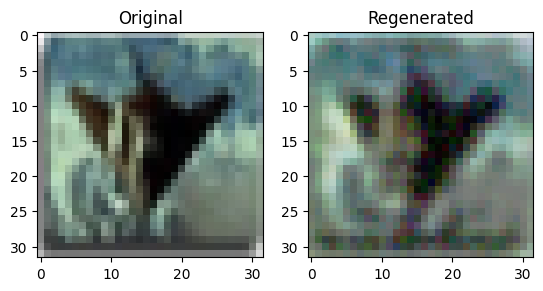

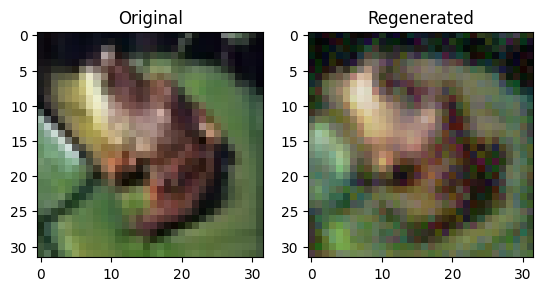

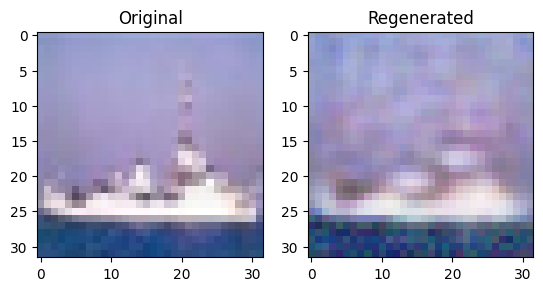

In [633]:
def display_images(original, regenerated):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original.permute(1, 2, 0).cpu().numpy())  # Convert tensor to image
    axes[0].set_title("Original")
    axes[1].imshow(regenerated.permute(1, 2, 0).cpu().detach().numpy())
    axes[1].set_title("Regenerated")
    plt.show()

for _ in range(4):
  img, _ = next(iter(train_loader))
  img = img.to(device)
  with torch.no_grad():
      img_regenerated = model(img)[0]
  display_images(img[0], img_regenerated)